In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from models import NNODEModel
from utiils import train_model, test_model

# Prepare date

In [4]:
data_path = '../data/'
data = pd.read_parquet(data_path+'SPY_hourly.parquet')

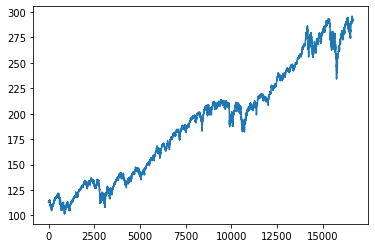

In [133]:
plt.plot(data.values)
plt.show()

In [115]:
price = data.values
price.shape

(16649, 1)

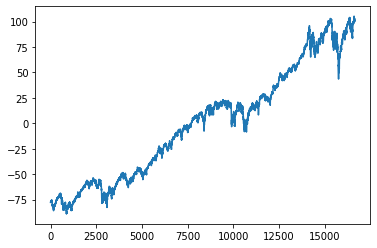

In [139]:
price_centered = price - price.mean()
plt.plot(price_centered)
plt.show()

In [140]:
price_stand = price_centered/price.std()

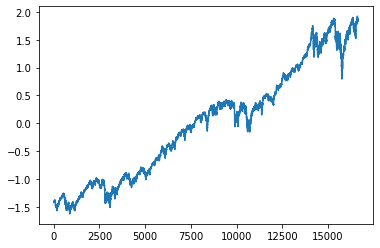

In [13]:
plt.plot(price_stand)
plt.show()

In [29]:
nan_detect = np.isnan(price_stand)

In [31]:
np.unique(nan_detect)

array([False])

In [85]:
price_stand.shape

(16649, 1)

In [8]:
def train_test_split(feature, ratio=0.8):
    train_size = int(len(feature)*ratio)
    train_set = feature[:train_size]
    test_set = feature[train_size:]
    return train_set, test_set

In [141]:
train_set, test_set = train_test_split(price_stand)

In [142]:
print('size')
print('training: ', train_set.shape)
print('test:', test_set.shape)

size
training:  (13319, 1)
test: (3330, 1)


In [122]:
train_set[:,0].reshape(1331, 10)

array([[-1.41977533, -1.41484644, -1.41174307, ..., -1.41639813,
        -1.40644907, -1.41028265],
       [-1.41046521, -1.41210817, -1.41046521, ..., -1.40425846,
        -1.40535376, -1.40024232],
       [-1.4033457 , -1.41247327, -1.40188529, ..., -1.39513088,
        -1.3973215 , -1.39586109],
       ...,
       [ 1.03353378,  1.02002497,  1.0176518 , ...,  1.02750958,
         1.02988275,  1.023676  ],
       [ 1.0293351 ,  1.03043041,  1.03024785, ...,  1.03426399,
         1.03426399,  1.03554185],
       [ 1.03554185,  1.03499419,  1.03280357, ...,  1.03554185,
         1.03736736,  1.02915255]])

In [179]:
train_set[:-5].shape

(13314, 1)

In [49]:
test_set[:-9].shape

(3321, 1)

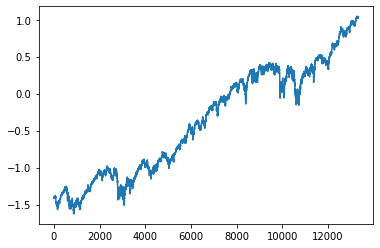

In [47]:
plt.plot(train_set[1:])
plt.show()

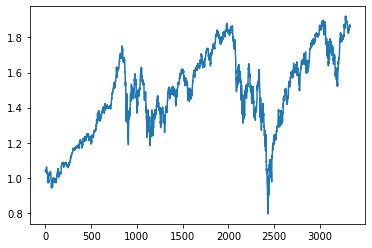

In [48]:
plt.plot(test_set[1:])
plt.show()

In [143]:
train_set_mis = train_set[:-5]
test_set_mis = test_set[:-6]

In [144]:
print('size')
print('training: ', train_set_mis.shape)
print('test:', test_set_mis.shape)

size
training:  (13314, 1)
test: (3324, 1)


In [145]:
train_input = torch.FloatTensor(train_set_mis[:-5])
train_target = torch.FloatTensor(train_set_mis[5:])
test_input = torch.FloatTensor(test_set_mis[:-5])
test_target = torch.FloatTensor(test_set_mis[5:])

In [146]:
print('size')
print('training input: ', train_input.shape)
print('test input:', test_input.shape)
print('training target:', train_target.shape)
print('test target:', test_target.shape)

size
training input:  torch.Size([13309, 1])
test input: torch.Size([3319, 1])
training target: torch.Size([13309, 1])
test target: torch.Size([3319, 1])


In [147]:
# matrix data creation, How to extend to multiple time series
def create_matrix_time(tensor, N):
    new_tensor = torch.zeros(N, tensor.size(0) - N + 1)
    for k in range(new_tensor.size(1)):
        new_tensor[:,k] = tensor[k:(k + N)].squeeze()
    return new_tensor

In [148]:
#y means target, x means input
N = 10
train_x = create_matrix_time(train_input, N).permute(1,0)
train_y = create_matrix_time(train_target, N).permute(1,0)
test_x = create_matrix_time(test_input, N).permute(1,0)
test_y = create_matrix_time(test_target, N).permute(1,0)

In [149]:
print('train input size: ', train_x.shape)
print('train target size: ', train_y.shape)
print('test input size: ', test_x.shape)
print('train input size: ', test_y.shape)

train input size:  torch.Size([13300, 10])
train target size:  torch.Size([13300, 10])
test input size:  torch.Size([3310, 10])
train input size:  torch.Size([3310, 10])


# Create model: Tentative 2

In [58]:
class NeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetModel,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        #layers creation
        self.encoder = nn.Linear(in_features=self.input_dim, out_features=self.hidden_dim)
        self.ode = NNODEModel(in_dim=self.hidden_dim, hid_dim=self.hidden_dim, out_dim=self.hidden_dim)
        self.decoder = nn.Linear(in_features=self.hidden_dim, out_features=self.output_dim)
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.ode(out)
        out = self.decoder(out)
        return out
        

In [150]:
in_dim = 10
out_dim = 10
hid_dim = 3
model = NeuralNetModel(input_dim=in_dim, hidden_dim=hid_dim, output_dim=out_dim)

In [151]:
loss_fn = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=1e-2)
n_epoch = 1000
train_losses = []
test_losses = []

In [152]:
for epoch in range(n_epoch):
    model.train()
    train_loss,_ = train_model(model, train_x, train_y, loss_fn, optimizer, batch_size=10)
    train_losses.append(train_loss)
    model.eval()
    test_loss,_ = test_model(model, test_x, test_y, loss_fn, batch_size=10)
    test_losses.append(test_loss)
    if epoch%10 == 0:
        print('Epoch:', epoch+1, ', train_loss:', train_loss, ', test_loss:', test_loss)

Epoch: 1 , train_loss: 130.59306413475133 , test_loss: 50.4393300563097
Epoch: 11 , train_loss: 0.46058481205773205 , test_loss: 0.3478128299148011
Epoch: 21 , train_loss: 0.4532624817593387 , test_loss: 0.3426996347725435
Epoch: 31 , train_loss: 0.44745736773165845 , test_loss: 0.3384880498333587
Epoch: 41 , train_loss: 0.44221569746832756 , test_loss: 0.33445786358151963
Epoch: 51 , train_loss: 0.43740662844993494 , test_loss: 0.3306037153206489
Epoch: 61 , train_loss: 0.43294795057090596 , test_loss: 0.3269182761569027
Epoch: 71 , train_loss: 0.42878367085813807 , test_loss: 0.3233840326247446
Epoch: 81 , train_loss: 0.424871183299274 , test_loss: 0.319993894813706
Epoch: 91 , train_loss: 0.4211794503889905 , test_loss: 0.31674175783518876
Epoch: 101 , train_loss: 0.4176818605915287 , test_loss: 0.31361754666431807
Epoch: 111 , train_loss: 0.4143582556266665 , test_loss: 0.3106122538656564
Epoch: 121 , train_loss: 0.4111913436963732 , test_loss: 0.3077157492270999
Epoch: 131 , train

In [153]:
prediction = model(test_x)

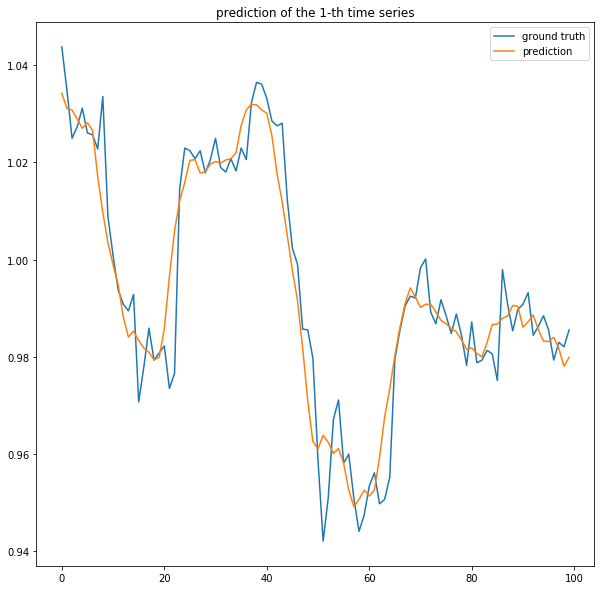

In [178]:
n=1
k=10
plt.figure(figsize=(10,10))
plt.plot(test_y[k:(k+100),n].numpy(), label='ground truth');
plt.plot(prediction[k:(k+100),n].detach().numpy(), label='prediction')
plt.legend()
plt.title('prediction of the ' + str(n) +'-th time series')
plt.show()

# Draft

In [16]:
N = 10
train_x = torch.zeros(10, train_input.size(0) - N + 1)
train_y = torch.zeros(10, train_target.size(0) - N + 1)

In [42]:
train_x.shape

torch.Size([10, 13301])

In [39]:
train_input[13300:13310].shape

torch.Size([10, 1])

In [44]:
for k in range(train_x.size(1)):
    train_x[:,k] = train_input[k:(k+10)].squeeze()

In [17]:
x = np.arange(101)
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [41]:
n=91
x[(n):(n+10)]

array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [29]:
X = np.zeros([10, 101 - 10 +1])

In [30]:
X.shape

(10, 92)

In [21]:
n=92

In [32]:
for k in range(n):
    X[:,k] = x[(k):(k+10)]

In [33]:
X

array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.],
       [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
         34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
         45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
     

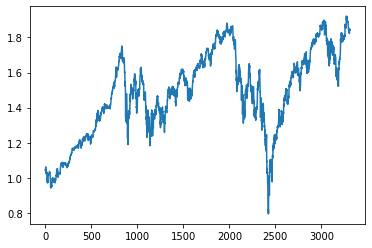

In [24]:
plt.plot(test_target.numpy())
plt.show()

# Create the model: OLD

In [56]:
class NeuralNetODE(nn.Module):
    def __init__(self, delta, in_dim, hid_dim, out_dim, bias=False):
        super(NeuralNetODE, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.delta = delta
        
        self.bias = bias
        
        #layers
        self.fc1 = nn.Linear(in_features=self.in_dim, out_features=self.in_dim)
        self.ode = NNODEModel(self.in_dim, self.hid_dim, self.out_dim)
        self.fc2 = nn.Linear(in_features=self.out_dim, out_features=self.out_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        for step in range(self.delta-1):
            out = self.ode(out)
        out = self.fc2(out)
        return out
    

In [41]:
def test_model(model, test_x, test_y, loss_fn, batch_size=1):
    test_loss = 0
    with torch.no_grad():
        for b in range(0, test_x.size(0), batch_size):
            pred = model(test_x.narrow(0, b, batch_size))
            loss = loss_fn(pred, test_y.narrow(0, b, batch_size))
            test_loss += loss.item()
        return test_loss, pred

In [59]:
input_dim = 1
delta = 11
model = NeuralNetODE(delta, input_dim, input_dim, input_dim)

In [60]:
loss_fn = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=1e-2)
n_epoch = 1000
train_losses = []
test_losses = []

In [61]:
#train with delta=10
for epoch in range(n_epoch):
    model.train()
    train_loss,_ = train_model(model, train_input, train_target, loss_fn, optimizer, batch_size=10)
    train_losses.append(train_loss)
    model.eval()
    test_loss,_ = test_model(model, test_input, test_target, loss_fn, batch_size=10)
    test_losses.append(test_loss)
    if epoch%10 == 0:
        print('Epoch:', epoch+1, ', train_loss:', train_loss, ', test_loss:', test_loss)

Epoch: 1 , train_loss: 1915.174315044389 , test_loss: 391.83054272830486
Epoch: 11 , train_loss: 1.3919402390502 , test_loss: 1.2260340508510126
Epoch: 21 , train_loss: 1.3956626165195303 , test_loss: 3.3308196816797135
Epoch: 31 , train_loss: 1.4015653989649763 , test_loss: 3.1995428941463615
Epoch: 41 , train_loss: 1.401200319010968 , test_loss: 2.7892327307399682
Epoch: 51 , train_loss: 1.3998806181352847 , test_loss: 2.455312435871747
Epoch: 61 , train_loss: 1.3986303848168973 , test_loss: 2.206945863974397
Epoch: 71 , train_loss: 1.3975903812834076 , test_loss: 2.0205937159698806
Epoch: 81 , train_loss: 1.396745416011072 , test_loss: 1.8776216131791443
Epoch: 91 , train_loss: 1.3960407954973562 , test_loss: 1.765225535405989
Epoch: 101 , train_loss: 1.3954626052081949 , test_loss: 1.675060985970049
Epoch: 111 , train_loss: 1.3949678189874248 , test_loss: 1.6009792413588002
Epoch: 121 , train_loss: 1.3945521404248211 , test_loss: 1.5392713281107717
Epoch: 131 , train_loss: 1.394187

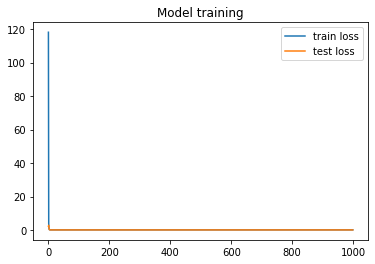

In [95]:
#with delta = 1
plt.figure()
plt.plot(train_losses, label='train loss');
plt.plot(test_losses, label='test loss')
plt.title('Model training')
plt.legend()
plt.show()

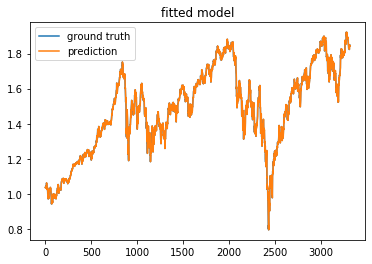

In [98]:
#with delta = 1
prediction = model(test_input)
plt.figure()
plt.plot(test_target.numpy(), label='ground truth');
plt.plot(prediction.detach().numpy(), label='prediction')
plt.title('fitted model')
plt.legend()
plt.show()

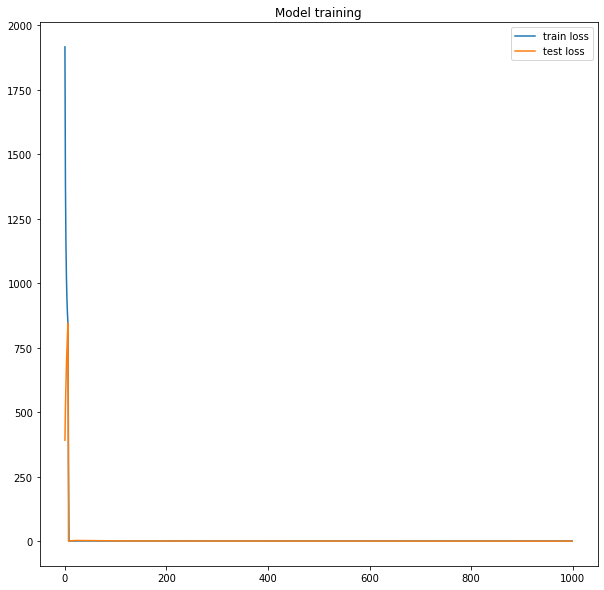

In [62]:
#with delta = 10
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train loss');
plt.plot(test_losses, label='test loss')
plt.title('Model training')
plt.legend()
plt.show()

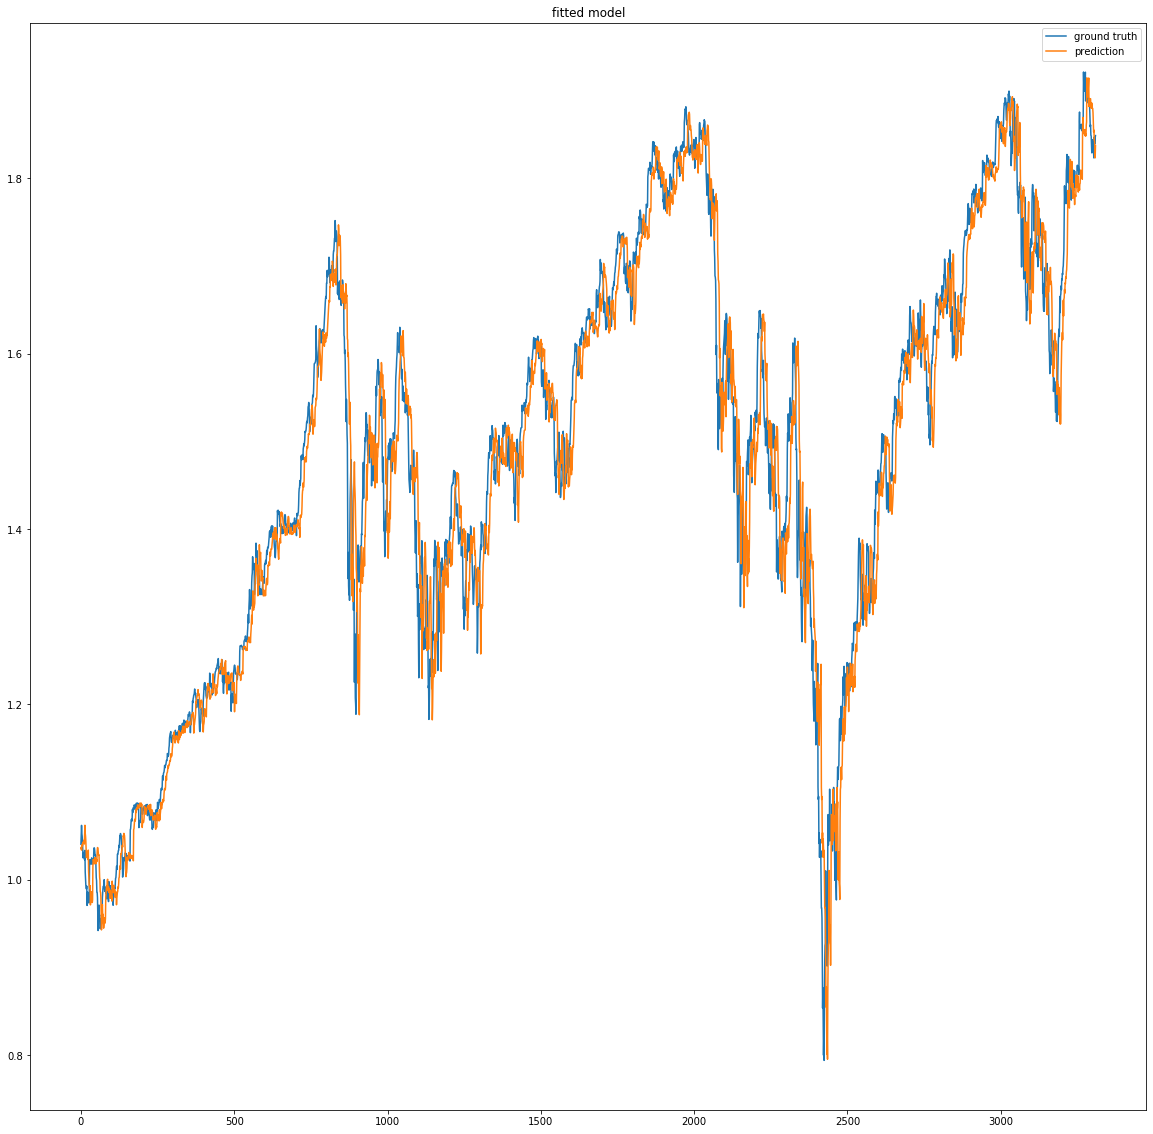

In [64]:
#with delta = 10
prediction = model(test_input)
plt.figure(figsize=(20,20))
plt.plot(test_target.numpy(), label='ground truth');
plt.plot(prediction.detach().numpy(), label='prediction')
plt.title('fitted model')
plt.legend()
plt.show()

In [81]:
model(torch.Tensor(np.arange(1,10)).unsqueeze(1))


tensor([[1.0004],
        [1.9925],
        [2.9768],
        [3.9511],
        [4.9132],
        [5.8611],
        [6.7929],
        [7.7069],
        [8.6015]], grad_fn=<AddmmBackward>)

In [82]:
np.arange(1,10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [79]:
torch.Tensor(np.arange(1,10)).unsqueeze(1)

tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])